## Homework: Problem 2

a) Implement the forward kinematics and inverse kinematics for a spatial-3R robot shown below. The lengths of the links L1, L2 and L3 are all 1m. The first revolute joint rotates about an axis that is vertical in the plane of the page. The second and third revolute joints rotate about axes that are normal to the page.


b) Implement a PD based trajectory-tracking controller for the robot to track the end-effector trajectories defined by the function 'trajectory(t)' which is implemented in this file. 

c) Provide plots comparing the desired and actual values to show the tracking performance of the controller. Show plots for the joint angles and the end-effector co-ordinates.

<div>
<img src="figures/spatial_3R.png" width="400">
</div>

In [142]:
###############################
# Import the necessary modules
###############################

# The PyBullet physics simulation library
import pybullet as p
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [143]:
def make_cap(a):
    a1=a[0, 0]
    a2=a[1, 0]
    a3=a[2, 0]

    a_cap=np.array([[0, -a3, a2], [a3, 0, -a1], [-a2, a1, 0]])

    return(a_cap)

def make_e_power_omegacap_theta(omega, theta):
    omega_cap=make_cap(omega)
    e_power_omegacap_theta=np.identity(3) + omega_cap*math.sin(theta) + np.matmul(omega_cap, omega_cap)*(1-math.cos(theta))
    return(e_power_omegacap_theta)

def give_p(omega, theta, v):
    omega_cap=make_cap(omega)
    e_power_omegacap_theta=make_e_power_omegacap_theta(omega, theta)
    p=np.matmul(np.matmul(np.identity(3)-e_power_omegacap_theta, omega_cap) + theta*np.matmul(omega, np.transpose(omega)), v)
    return(p)

         



In [144]:
#################################################################
# Forward and Inverse kinematics modules for the spatial-3R robot
#################################################################

def forward_kinematics(theta1, theta2, theta3, l1, l2, l3):
    '''
    Forward kinematics module for a spatial-3R chain.
    The base of the manipulator is assumed to be placed at the
    coordinates [0,0, 0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- theta3: Relative angle between link l2 and l3 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    --- l3: Lenght of link l3 (in m)
    Ret:
    --- [x, y, z]: Position co-ordinates of the end-effector (in m)
    '''
    
    # WRITE YOUR CODE HERE #
    theta1=math.radians(theta1)
    theta2=math.radians(theta2)
    theta3=math.radians(theta3)

    omega1=np.array([[0], [0], [1]])
    omega2=np.array([[1], [0], [0]])
    omega3=np.array([[1], [0], [0]])

    q1=np.array([[0], [0], [0]])
    q2=np.array([[0], [0], [l1]])
    q3=np.array([[0], [l2*math.sin(theta2)], [l1+l2*math.cos(theta2)]])

    v1 = -np.transpose(np.cross(np.transpose(omega1), np.transpose(q1)))
    v2 = -np.transpose(np.cross(np.transpose(omega2), np.transpose(q2)))
    v3 = -np.transpose(np.cross(np.transpose(omega3), np.transpose(q3)))   

    gst_0=np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, l1+l2+l3], [0, 0, 0, 1]])

    p1=give_p(omega1, theta1, v1)
    p2=give_p(omega2, theta2, v2)
    p3=give_p(omega3, theta3, v3)

    exp_epsi_1=np.array([[math.cos(theta1), -math.sin(theta1), 0, p1[0, 0]], 
                         [math.sin(theta1), math.cos(theta1), 0, p1[1, 0]],
                         [0, 0, 1, p1[2, 0]],
                         [0, 0, 0, 1]])
    
    exp_epsi_2=np.array([[1, 0, 0, p2[0, 0]], 
                         [0, math.cos(theta2), -math.sin(theta2), p2[1, 0]],
                         [0, math.sin(theta2), math.cos(theta2), p2[2, 0]],
                         [0, 0, 0, 1]])
    
    exp_epsi_3=np.array([[1, 0, 0, p1[0, 0]], 
                         [0, math.cos(theta3), -math.sin(theta3), p3[1, 0]],
                         [0, math.sin(theta3), math.cos(theta3), p3[2, 0]],
                         [0, 0, 0, 1]])

    gst_theta=np.matmul(np.matmul(exp_epsi_1, exp_epsi_2), np.matmul(exp_epsi_3, gst_0))

    x=gst_theta[0, 3]
    y=gst_theta[1, 3]
    z=gst_theta[2, 3]

    
    return [x, y, z]

def inverse_kinematics(x, y, z, l1, l2, l3, branch=1):
    '''
    Inverse kinematics modules for the serial-3R manipulator.
    The base of the manipulator is placed at [0,0, 0].    
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- z : Z co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- l3: Length of link l3
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2, theta3]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2, and relative angle between links l2 and l3 respectively.
    '''

    # WRITE YOUR CODE HERE #
    if(x**2+y**2>0):
        q1=math.atan2(y, x)
        s1=math.cos(q1)
        c1=math.sin(q1)

        c3=(x**2 + y**2 + (z-1)**2 - l2**2 - l3**2)/(2*l2*l3)
        s3=math.sqrt(1-c3**2)
        q3=math.atan2(c3, s3)

        if(s3>=-0.173 and s3<=0.173):
            if(x**2+y**2+(z-1)**2>0):
                s2=((l2+l3*c3)*(z-l1)-(l3*s3)*(c1*x+y*s1))/((l3**2)-(l2+l3*c3)**2)
                c2=math.sqrt(1-s2**2)
                q2=math.atan2(s2, c2)

                # Solution found; return the joint angles
                theta1 = q1
                theta2 = q2-q1
                theta3 = q3-q2-q1
                return True, [theta1, theta2, theta3]
            else:
                return False, [0,0,0]    
        else:
            print('Position out of workspace')
            return False, [0,0,0]
    else:
        return False, [0,0,0]

In [145]:
# theta1=math.radians(30)
# omega1=np.array([[0], [0], [1]])
# q1=np.array([[1], [1], [1]])
# v1 = -np.transpose(np.cross(np.transpose(omega1), np.transpose(q1)))
# print(give_p(omega1, theta1, v1))

In [146]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = p.connect(p.DIRECT) # or p.GUI


# Load the URDF of the plane that forms the ground
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = p.loadURDF("plane.urdf")


# Load the URDF of the robot
robot = p.loadURDF("spatial_3R_robot.urdf")

In [147]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
p.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
p.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [148]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
p.setJointMotorControl2(robot, 0, p.VELOCITY_CONTROL, force=0)
p.setJointMotorControl2(robot, 1, p.VELOCITY_CONTROL, force=0)
p.setJointMotorControl2(robot, 2, p.VELOCITY_CONTROL, force=0)

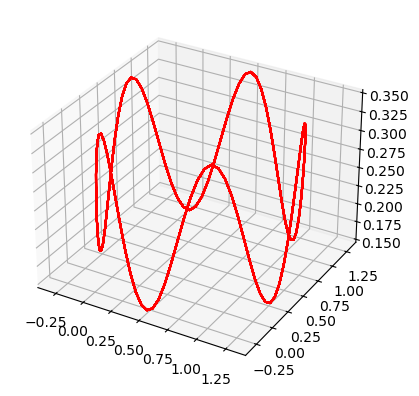

In [149]:
#######################################
# Define functions for the trajectories
#######################################


def trajectory(t):
    '''
    A function to specify the trajectory
    Args:
    t: time
    Returns:
    x: X coordinate of the end-effector
    y: Y coordinate of the end-effector
    z: Z coordinate of the end-effector
    '''
    
    r = 0.4
    a = 0.05

    r=r*2
    a=a*2


    
    omega = 2*np.pi*2
    omega_z = 2*np.pi*10
    
    # Centre of the trajectory
    [x0, y0, z0] = [0.5, 0.5,0.25]
    
    x = x0 + r*np.cos(omega*t)
    y = y0 + r*np.sin(omega*t)
    z = z0 + a*np.sin(omega_z * t);
    
    return x, y, z


# Plot the trajectory
x_plt = []; y_plt = []; z_plt = []
for t in np.arange(0, 5, 0.005):
    x, y, z = trajectory(t)
    x_plt.append(x)
    y_plt.append(y)
    z_plt.append(z)
        

ax = plt.axes( projection = '3d')
ax.plot3D(x_plt, y_plt, z_plt, 'red')
 
plt.show()

In [150]:
kp1=1
kp2=1
kp3=1

kd1=1
kd2=1
kd3=1

l1=1
l2=1
l3=1

bias1=0
bias2=0
bias3=0

In [151]:
##########################################
# Control loop to follow the trajectory
##########################################

# WRITE YOUR CODE HERE #
dt=0.005 #time interval
max_time=5

x_error_prior=0
y_error_prior=0
z_error_prior=0

theta1_error_prior=0
theta2_error_prior=0
theta3_error_prior=0

theta1_measured_plt=[]; theta2_measured_plt=[]; theta3_measured_plt=[];
theta1_desired_plt=[]; theta2_desired_plt=[]; theta3_desired_plt=[];

x_desired_plt=[]; y_desired_plt=[]; z_desired_plt=[];
x_measured_plt=[]; y_measured_plt=[]; z_measured_plt=[];

for t in np.arange (0, max_time, dt):
    theta1_measured, _, _, _ = p.getJointState(robot, 0)
    theta2_measured_temp, _, _, _ = p.getJointState(robot, 1)
    theta3_measured_temp, _, _, _ = p.getJointState(robot, 2)
    theta2_measured=theta2_measured_temp-theta1_measured
    theta3_measured=theta3_measured_temp-theta2_measured_temp-theta1_measured

    theta1_measured_plt.append(theta1_measured)
    theta2_measured_plt.append(theta2_measured)
    theta3_measured_plt.append(theta3_measured)


    [x_measured, y_measured, z_measured] = forward_kinematics(theta1_measured, theta2_measured, theta3_measured, l1, l2, l3)
    x_measured_plt.append(x_measured)
    y_measured_plt.append(y_measured)
    z_measured_plt.append(z_measured)

    x_t, y_t, z_t=trajectory(t)

    x_desired=x_t
    y_desired=y_t
    z_desired=z_t

    x_desired_plt.append(x_desired)
    y_desired_plt.append(y_desired)
    z_desired_plt.append(z_desired)

    valid, [theta1_desired, theta2_desired, theta3_desired] = inverse_kinematics(x_t, y_t, z_t, l1, l2, l3)
    
    theta1_desired_plt.append(theta1_desired)
    theta2_desired_plt.append(theta2_desired)
    theta3_desired_plt.append(theta3_desired)

    theta1_error=theta1_desired-theta1_measured
    theta2_error=theta2_desired-theta2_measured
    theta3_error=theta3_desired-theta3_measured

    theta1_derivative=(theta1_error-theta1_error_prior)/dt
    theta2_derivative=(theta2_error-theta2_error_prior)/dt
    theta3_derivative=(theta3_error-theta3_error_prior)/dt

    theta1_error_prior=theta1_error
    theta2_error_prior=theta2_error
    theta3_error_prior=theta3_error

    torque_joint1=theta1_error*kp1 + theta1_derivative*kd1 +bias1
    torque_joint2=theta2_error*kp2 + theta2_derivative*kd2 +bias2
    torque_joint3=theta3_error*kp3 + theta2_derivative*kd3 +bias3

    p.setJointMotorControl2(robot, 0, p.TORQUE_CONTROL, force=torque_joint1)
    p.setJointMotorControl2(robot, 1, p.TORQUE_CONTROL, force=torque_joint2)
    p.setJointMotorControl2(robot, 2, p.TORQUE_CONTROL, force=torque_joint3)
    p.stepSimulation()

    









Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out of workspace
Position out

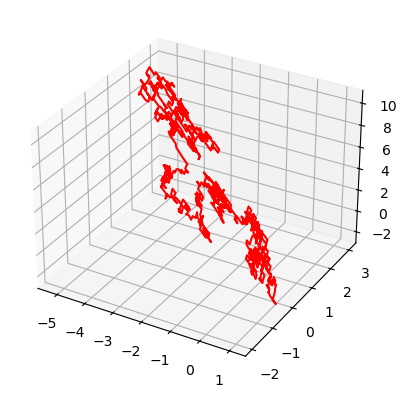

In [152]:
##########################################
# Plot the data in joint-space
##########################################

# WRITE YOUR CODE HERE #
ax = plt.axes( projection = '3d')
ax.plot3D(theta1_measured_plt, theta2_measured_plt, theta3_measured_plt, 'red')
 
plt.show()


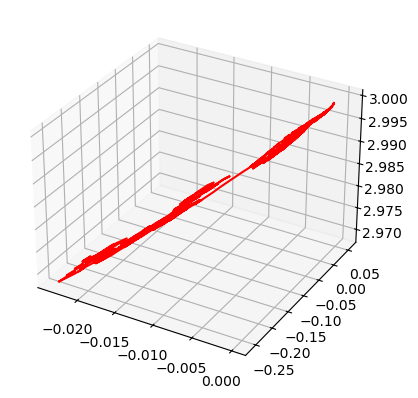

In [153]:
##########################################
# Plot the data in task-space
##########################################

# WRITE YOUR CODE HERE #
ax = plt.axes( projection = '3d')
ax.plot3D(x_measured_plt, y_measured_plt, z_measured_plt, 'red')
 
plt.show()
